In [2]:
%load_ext autoreload
%autoreload 1


import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
import sys
import copy
import itertools
from scipy.linalg import block_diag

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb.fisher.utils import plot_pn

print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CAMB 1.3.6 installed at /Users/louis/Code/CAMBfork/camb


In [3]:

lmax=2000
pars = camb.CAMBparams()
cosmo1_dict={'Omegam':0.315143, 'OmegaL':0.684857, 'OmegaB':0.0491168,'h0':0.6726, 'nS':0.963, 'w0':-1., 'wa':0., 'sg80':0.83} # we create a "cosmo" dictionary with Planck DR2 values (fiducial model)
h0=cosmo1_dict['h0']
ombh2=cosmo1_dict['h0']**2*cosmo1_dict['OmegaB']
omch2=cosmo1_dict['h0']**2*(cosmo1_dict['Omegam']-cosmo1_dict['OmegaB'])

pars.set_cosmology(H0=h0*1e2, ombh2=ombh2, omch2=omch2)

print('>Omega_M, Omega_L=',(pars.ombh2+pars.omch2)/(pars.H0/1e2)**2,1.-(pars.ombh2+pars.omch2+pars.omnuh2)/(pars.H0/1e2)**2)

pars.InitPower.set_params(As=2e-9, ns=cosmo1_dict['nS'])
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
#set Want_CMB to true if you also want CMB spectra or correlations
pars.Want_CMB = True
#NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinear = model.NonLinear_both
#
biasP=1.66 ; biasR=3.8
zobs=np.array([0.3])
sgzar=np.array([0.01])
# this dictionary considers both ADF (source_type="counts") and ARF (source_type="arf") for the same shell
pars.SourceWindows=[GaussianSourceWindow(redshift=zobs[0],source_type='counts',bias=biasP,sigma=sgzar[0],dlog10Ndm=0.),\
	GaussianSourceWindow(redshift=zobs[0],source_type='arf',bias=biasP,sigma=sgzar[0],dlog10Ndm=0.)] 
#We only consider RSD term among relativistic corrections
pars.SourceTerms.counts_redshift=True
pars.SourceTerms.counts_density=True
pars.SourceTerms.counts_lensing=False
pars.SourceTerms.counts_radial=False
pars.SourceTerms.use_21cm_mK=False

results = camb.get_results(pars)
cls1 = results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
#We drop the  RSD term and neglect all relativistic corrections (only density term)
pars.SourceTerms.counts_redshift=False
pars.SourceTerms.counts_density=True
results = camb.get_results(pars)
cls2 = results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
ll0=np.arange(len(cls1['TxT'])) ; ll2=ll0[2:]
clADF=cls1['W1xW1'] ; clARF=cls1['W2xW2']
clADFr=cls2['W1xW1'] ; clARFr=cls2['W2xW2']
#



>Omega_M, Omega_L= 0.31514300000000006 0.683430935508899
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999686283     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999686283     


[]

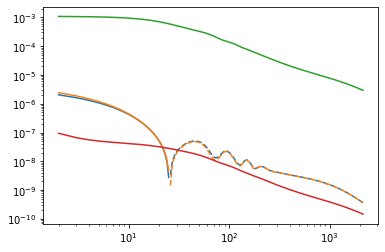

In [6]:
plt.figure()

plot_pn(ll0, cls2['W1xW2'])
plot_pn(ll0, cls1['W1xW2'])
plot_pn(ll0, cls1['W1xW1'])
plot_pn(ll0, cls1['W2xW2'])


plt.loglog()

<Figure size 432x288 with 0 Axes>

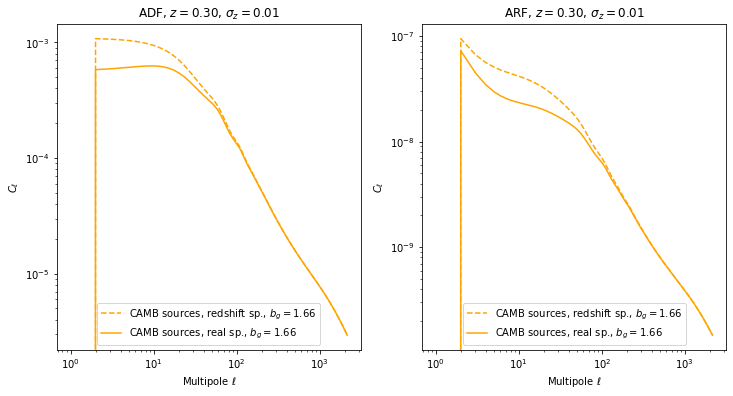

In [4]:
plt.clf()
fig,ax1=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
#
ax1[0].loglog(ll0,clADF,color='orange',ls='dashed',label='CAMB sources, redshift sp., $b_g=$%.2f'%biasP)
ax1[0].plot(ll0,clADFr,color='orange',label='CAMB sources, real sp., $b_g=$%.2f'%biasP)
ax1[0].set_xlabel('Multipole $\ell$') ; ax1[0].set_ylabel('$C_{\ell}$') ; # ax1[0].set_xlim([1.,2*ns]) #; ax1[0].set_yscale('log')
ax1[0].set_title('ADF, $z=$%.2f, $\sigma_z=$%.2f'%(zobs[0],sgzar[0])) ; ax1[0].legend(loc='best',prop={'size': 10}) ; #ax1[0].set_ylim([0e0,8e-3])
#
sg=sgzar[0]
ax1[1].loglog(ll0,clARF,color='orange',ls='dashed',label='CAMB sources, redshift sp., $b_g=$%.2f'%biasP)
ax1[1].plot(ll0,clARFr,color='orange',label='CAMB sources, real sp., $b_g=$%.2f'%biasP)
ax1[1].set_xlabel('Multipole $\ell$') ; ax1[0].set_ylabel('$C_{\ell}$')  ; ax1[1].set_ylabel('$C_{\ell}$') ; #ax1[1].set_xlim([1.,2.*ns]) #; ax1[1].set_yscale('log')
ax1[1].set_title('ARF, $z=$%.2f, $\sigma_z=$%.2f'%(zobs[0],sgzar[0])) ; ax1[1].legend(loc='best', prop={'size': 10}) ; # ax1[1].set_ylim([0e0,0.6e-6])
#
# plt.savefig('C_ell_tst.png',dpi=300)


In [17]:
mnus = np.array([0.06, 0.1])
cls = []

for i, mnu in enumerate(mnus):
    pars.set_cosmology(H0=cosmo1_dict['h0']*100, mnu=mnu)
    results = camb.get_results(pars)
    cls.append(results.get_cmb_unlensed_scalar_array_dict(raw_cl=True))

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999720550     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999692067     


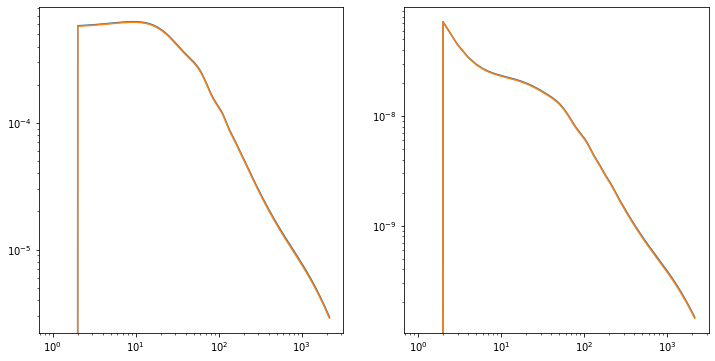

In [23]:
fig,ax1=plt.subplots(nrows=1,ncols=2,figsize=(12,6))

for i, mnu in enumerate(mnus):
    ax1[0].loglog(cls[i]['W1xW1'])
    ax1[1].loglog(cls[i]['W2xW2'])    

/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_1250/3780770863.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(cls[0]['W2xW2']/cls[1]['W2xW2'])
/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_1250/3780770863.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(cls[0]['W1xW1']/cls[1]['W1xW1'])


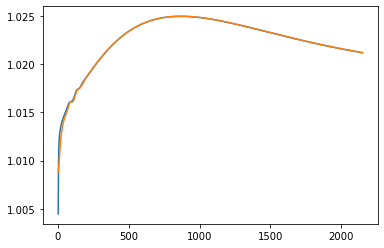

In [14]:
plt.plot(cls[0]['W2xW2']/cls[1]['W2xW2'])
plt.plot(cls[0]['W1xW1']/cls[1]['W1xW1'])

In [12]:
cls[0].keys()

dict_keys(['TxT', 'TxE', 'TxP', 'TxW1', 'TxW2', 'ExT', 'ExE', 'ExP', 'ExW1', 'ExW2', 'PxT', 'PxE', 'PxP', 'PxW1', 'PxW2', 'W1xT', 'W1xE', 'W1xP', 'W1xW1', 'W1xW2', 'W2xT', 'W2xE', 'W2xP', 'W2xW1', 'W2xW2'])

# Fisher matrix 

In [36]:
fiducial_ffp10_plancklens = {
#     'Alens':1,
    'As': 2.119631e-09,
    'ns': 0.9636852,
    'H0': 67.01904,
#     'theta_MC_100':0.010407224216796775 *100,
    'ombh2': 0.02216571,
    'omch2': 0.1202944,
    'tau':0.06018107,
    'mnu':0.1,
    'omk':0,
    'w':-1,
#     'wa':0
}

fiducials = fiducial_ffp10_plancklens

In [84]:
# Params to derivate 

# params = ['As', 'ns', 'H0', 'ombh2', 'omch2', 'mnu']
params = ['As']

npar= len(params)

In [45]:
# Cls to use in the Fisher matrix 

cl_keys = ['W1xW1', 'W1xW2', 'W2xW2']

# Get the gaussian covariance matrix

In [111]:
# Fiducial Cls 
pars.set_cosmology(H0=fiducials['H0'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])

pars.InitPower.set_params(As=fiducials['As'], ns=fiducials['ns'], r=0)
results = camb.get_results(pars)

cls_fid = results.get_cmb_unlensed_scalar_array_dict(raw_cl=True)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.30000000000056065     


In [112]:
lmin = 10

ells = np.arange(lmin, lmax) 
dell = np.ones_like(ells)

In [113]:
cls_fid

{'TxT': array([0.00000000e+00, 0.00000000e+00, 1.45672475e-10, ...,
        3.12807019e-17, 3.10878653e-17, 3.08953759e-17]),
 'TxE': array([ 0.00000000e+00,  0.00000000e+00,  3.95318573e-13, ...,
        -8.06809215e-20, -7.03329151e-20, -6.05644542e-20]),
 'TxP': array([0.00000000e+00, 0.00000000e+00, 4.71842203e-10, ...,
        1.01673733e-22, 1.00909417e-22, 1.00147063e-22]),
 'TxW1': array([ 0.00000000e+00,  0.00000000e+00,  2.21227403e-08, ...,
        -1.16528842e-37, -5.82801857e-38,  0.00000000e+00]),
 'TxW2': array([ 0.00000000e+00,  0.00000000e+00,  1.11523358e-09, ...,
        -7.92137960e-41, -3.96176145e-41,  0.00000000e+00]),
 'ExT': array([ 0.00000000e+00,  0.00000000e+00,  3.95318573e-13, ...,
        -8.06809215e-20, -7.03329151e-20, -6.05644542e-20]),
 'ExE': array([0.00000000e+00, 0.00000000e+00, 4.87471241e-15, ...,
        8.78722199e-19, 8.83356676e-19, 8.88040454e-19]),
 'ExP': array([ 0.00000000e+00,  0.00000000e+00, -2.05684234e-12, ...,
         6.76940260e-

In [114]:
cls_fid[key]

array([0.00000000e+00, 0.00000000e+00, 6.07252370e-04, ...,
       3.10404049e-06, 3.10183099e-06, 3.09962424e-06])

In [134]:
ncl = len(cl_keys)

fsky = 0.363609919  # Euclid fsky 


cov_tot = []
invcov_l = []
for il, l in enumerate(ells):
#     print(il, l)
    cl_dict_l = {}
    nl_dict = {}
#     for idx, (i, j) in enumerate(indices_wl):
#         spectrum = spectrum = 'W{}xW{}'.format(i+11, j+11)
    
    # To do : Add noise 
    for key in cl_keys:
        cl_dict_l[key] = cls_fid[key][l]
        
        nl_dict[key] = 0
#         if (i == j):
#             nl_dict[key] = sig_eps**2/ng_i
            
            
#     cl_keys = list(cl_dict_l.keys())

#     ncl = len(cl_keys)

    cov_l = np.zeros([ncl, ncl])

    # Get symetric Cls for permutations
    for key in cl_keys:
        probeA, probeB = key.split('x')
        cl_dict_l['x'.join([probeB, probeA])] = cl_dict_l[key]
        nl_dict['x'.join([probeB, probeA])] = nl_dict[key]

    for (idx1, key1), (idx2, key2) in itertools.combinations_with_replacement(enumerate(cl_keys), 2):
        # print(key1, key2)
        probeA, probeB = key1.split('x')
        probeC, probeD = key2.split('x')
        # if il == 0:
        #     print(probeA, probeB, probeC, probeD)
        cov_l[idx1, idx2] = 1. / (fsky * (2. * l + 1.) * dell[il]) \
            * (
                (cl_dict_l['x'.join([probeA, probeC])] + nl_dict['x'.join([probeA, probeC])]) *
                (cl_dict_l['x'.join([probeB, probeD])] + nl_dict['x'.join([probeB, probeD])]) +
                (cl_dict_l['x'.join([probeA, probeD])] + nl_dict['x'.join([probeA, probeD])]) *
                (cl_dict_l['x'.join([probeB, probeC])] + nl_dict['x'.join([probeB, probeC])])
        )

    # Get the symmetric matrix
    cov_l = cov_l + cov_l.T - np.diag(cov_l.diagonal())
    cov_tot.append(cov_l)
    invcov_l.append(np.linalg.inv(cov_l))
    
covmat = block_diag(*cov_tot)

# # np.save('covmat_euclid_wl', np.array(cov_tot))

In [116]:
def cov_to_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

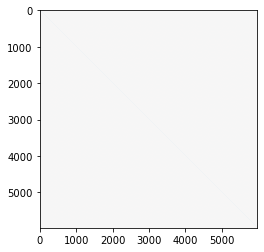

In [117]:
plt.imshow(cov_to_corr(covmat), cmap='RdBu', vmin=-1, vmax=1)

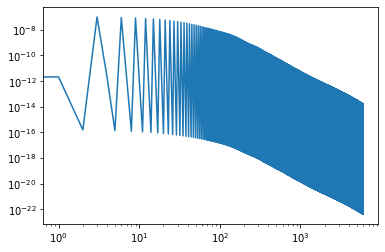

In [118]:
plt.loglog(np.diag(covmat))

In [119]:
invcov = np.linalg.inv(covmat)

In [120]:
eps = 0.02

delta_par = {}
cls_dpar_p = {}
cls_dpar_m = {}

for par in params:
    print(par)
    dpar_p = copy.deepcopy(fiducials)
    dpar_m = copy.deepcopy(fiducials)
    
    if dpar_p[par] == 0:
        dpar_p[par] = eps
        dpar_m[par] = - eps
        delta_par[par] = 2*eps
    else:
        dpar_p[par] *= 1 + eps
        dpar_m[par] *= 1 - eps
        delta_par[par] = 2*eps*fiducials[par]
        
    # Plus
    pars.set_cosmology(H0=dpar_p['H0'], ombh2=dpar_p['ombh2'], omch2=dpar_p['omch2'], mnu=dpar_p['mnu'], omk=dpar_p['omk'], tau=dpar_p['tau'])
    
    pars.InitPower.set_params(As=dpar_p['As'], ns=dpar_p['ns'], r=0)
    results_p = camb.get_results(pars)
    
    cls_dpar_p[par] = results_p.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
 
    # Minus 
    pars.set_cosmology(H0=dpar_m['H0'], ombh2=dpar_m['ombh2'], omch2=dpar_m['omch2'], mnu=dpar_m['mnu'], omk=dpar_m['omk'], tau=dpar_m['tau'])
    
    pars.InitPower.set_params(As=dpar_m['As'], ns=dpar_m['ns'], r=0)

    results_m = camb.get_results(pars)
    
    cls_dpar_m[par] = results_m.get_cmb_unlensed_scalar_array_dict(raw_cl=True)


As
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.30000000000056065     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.30000000000056065     
ns
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.30000000000056065     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.30000000000056065     
H0
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999690580     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999896310     
ombh2
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.30000000000044963     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999634996     
omch2
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29999999999990729     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.29

In [140]:
dcls_dpar = {}

for par in params:
    dcls_dpar[par] = {}
    for il, ell in enumerate(ells):
        dcls_dpar[par][ell] = np.zeros(len(cl_keys))
        for ik, key in enumerate(cl_keys):
            dcls_dpar[par][ell][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
#     dcls_dpar[par] = np.array(dcls_dpar[par])

In [141]:
cl_keys

['W1xW1', 'W1xW2', 'W2xW2']

In [142]:
fisher = np.zeros([npar, npar])
# invcov_w = like_euclid_wl.invcovmat_l

for (i1, par1), (i2, par2) in itertools.combinations_with_replacement(enumerate(params), 2):
    for il, l in enumerate(ells):
        fisher[i1, i2] += np.dot(np.dot(dcls_dpar[par][l], invcov_l[il]), dcls_dpar[par2][l])

fisher = fisher + fisher.T - np.diag(fisher.diagonal())

In [149]:
latex = {
    'logA':r'\log(10^{10} A_\mathrm{s})',
    'As':r'A_\mathrm{s})',
    'ns': r'n_\mathrm{s}', 
    'theta_MC_100':r'100\theta_\mathrm{MC}', 
    'ombh2':r'\Omega_\mathrm{b} h^2', 
    'omch2':r'\Omega_\mathrm{c} h^2', 
    'tau':r'\tau_\mathrm{reio}', 
    'mnu':r'\sum m_\nu', 
    'omk':r'\Omega_k', 
    'w':r'w_0',
    'wa':r'w_\mathrm{a}',
    'H0':r'H_0'
}

labels = [latex[par] for par in params]

mean = [fiducials[par] for par in list(params)]

In [153]:
np.linalg.inv(fisher)

array([[-1.77402964e-15,  1.77402964e-15, -0.00000000e+00,
        -1.04259348e-31, -2.09719021e-31, -1.00211036e-31],
       [ 1.77402964e-15, -7.64017843e-07,  7.64017841e-07,
         1.63803324e-23,  9.02831309e-23, -5.59637077e-24],
       [ 3.13362856e-31,  7.64017841e-07, -8.13177199e-07,
         4.91593574e-08, -8.48230199e-23,  1.10853270e-23],
       [-1.76443087e-31,  0.00000000e+00,  4.91593574e-08,
        -1.95882509e-08, -2.95711065e-08, -1.24153153e-23],
       [-2.57168532e-31, -0.00000000e+00,  4.25414064e-24,
        -2.95711065e-08, -4.19872110e-08,  7.15583175e-08],
       [ 2.51215463e-31,  0.00000000e+00,  4.68982847e-24,
        -6.81544177e-24,  7.15583175e-08,  1.96441734e-06]])

In [155]:
for ip, par in enumerate(params):
    if fisher[ip, ip] == 0:
        print("{} : 0 ".format(par))
    else:
#         print("{} : {} ".format(par, np.sqrt(1/fish[ip, ip]) / fiducials[par]))
        
#         print("{} : {} ".format(par, np.sqrt(np.linalg.inv(fisher)[ip, ip]) / fiducials[par])) 
        print(np.linalg.inv(fisher)[ip, ip])
        print("{} : {} ".format(par, np.sqrt(np.linalg.inv(fisher)[ip, ip]) / fiducials[par]))             

-1.7740296423413552e-15
As : nan 
-7.64017843121968e-07
ns : nan 
-8.131771987502846e-07
H0 : nan 
-1.9588250854997115e-08
ombh2 : nan 
-4.1987210968555505e-08
omch2 : nan 
1.9644173441844618e-06
mnu : 0.014015767350325352 


/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_1250/3634946764.py:9: RuntimeWarning: invalid value encountered in sqrt
  print("{} : {} ".format(par, np.sqrt(np.linalg.inv(fisher)[ip, ip]) / fiducials[par]))


In [148]:
gauss = GaussianND(mean, np.linalg.inv(fisher), names=params, labels=labels)
# Plots
# from getdist import plots
# from getdist.gaussian_mixtures import GaussianND

ModuleNotFoundError: No module named 'getdist'